In [1]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from arch import arch_model
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

In [2]:
def MAE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred)))

def MAPE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred))/(y_true))*100

In [3]:
df_new = pd.read_csv('Mouna_Loa_Weekly_Data.csv')
df_new.head(20)

,Year,Month,Day,Year(decimal),CO2(PPM)
0,1974,5,19,1974.3795,333.37
1,1974,5,26,1974.3986,332.95
2,1974,6,2,1974.4178,332.35
3,1974,6,9,1974.4370,332.20
4,1974,6,16,1974.4562,332.37
5,1974,6,23,1974.4753,331.73
6,1974,6,30,1974.4945,331.68
7,1974,7,7,1974.5137,331.46
8,1974,7,14,1974.5329,330.83
9,1974,7,21,1974.5521,330.76


In [4]:
df_new.tail()

,Year,Month,Day,Year(decimal),CO2(PPM)
2472,2021,10,3,2021.7548,413.63
2473,2021,10,10,2021.7740,413.89
2474,2021,10,17,2021.7932,414.36
2475,2021,10,24,2021.8123,413.90
2476,2021,10,31,2021.8315,414.17


In [5]:
df_new['CO2(PPM)'].min()

-999.99

In [6]:
df_new.replace(-999.99,np.nan,inplace=True)

In [7]:
df = df_new.fillna(df_new.rolling(7,min_periods=1).mean())

In [8]:
df.isnull().sum()

Year             0
Month            0
Day              0
Year(decimal)    0
CO2(PPM)         0
dtype: int64

In [9]:
time = pd.date_range(start='5/19/1974',periods=2477,freq='W')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Year','Month','Year(decimal)','Day'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [11]:
df.shape

(2477, 1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2477 entries, 1974-05-19 to 2021-10-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CO2(PPM)  2477 non-null   float64
dtypes: float64(1)
memory usage: 38.7 KB


In [13]:
df.head()

,CO2(PPM)
time_stamp,
1974-05-19,333.37
1974-05-26,332.95
1974-06-02,332.35
1974-06-09,332.20
1974-06-16,332.37


In [14]:
df.tail()

,CO2(PPM)
time_stamp,
2021-10-03,413.63
2021-10-10,413.89
2021-10-17,414.36
2021-10-24,413.90
2021-10-31,414.17


In [15]:
df

,CO2(PPM)
time_stamp,
1974-05-19,333.37
1974-05-26,332.95
1974-06-02,332.35
1974-06-09,332.20
1974-06-16,332.37
...,...
2021-10-03,413.63
2021-10-10,413.89
2021-10-17,414.36


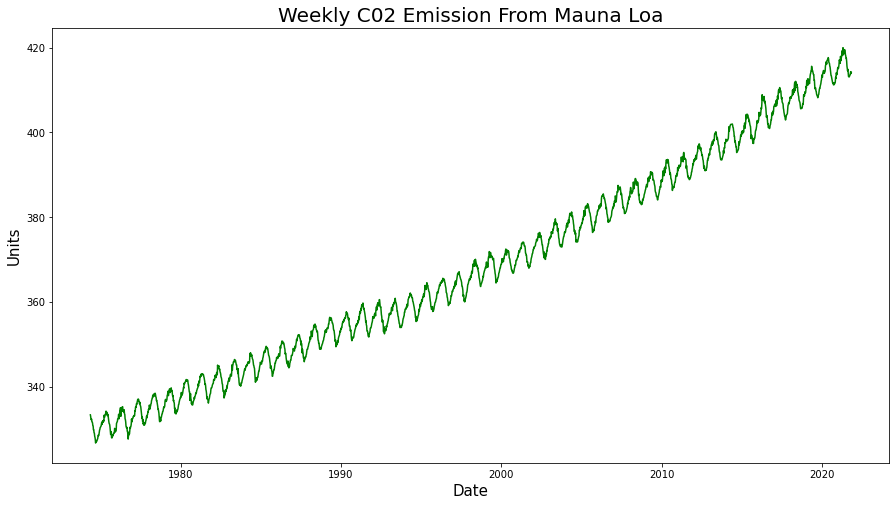

In [16]:
plt.plot(df,color='green')
plt.title('Weekly C02 Emission From Mauna Loa',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [17]:
plt.rcParams['figure.figsize'] = [15,8]

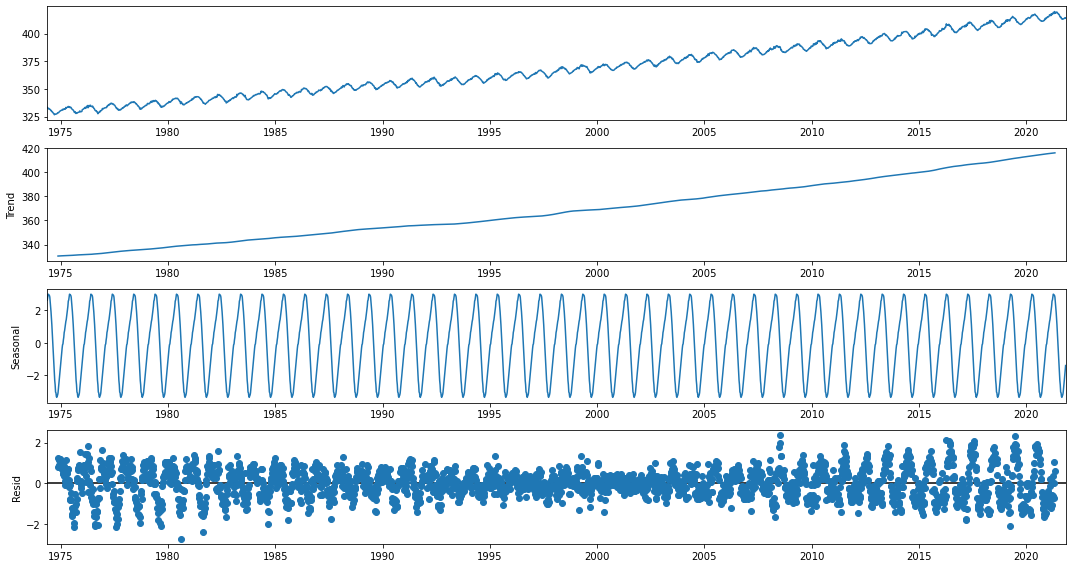

In [18]:
decomposition_model = seasonal_decompose(df,model='additive')
decomposition_model.plot();

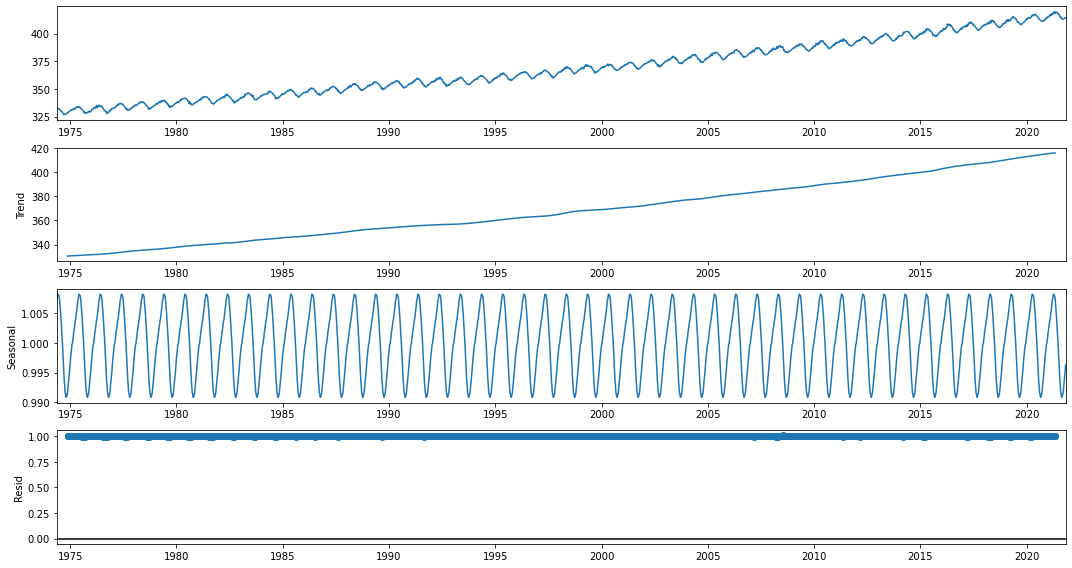

In [19]:
decomposition_model = seasonal_decompose(df,model='multiplicative')
decomposition_model.plot();

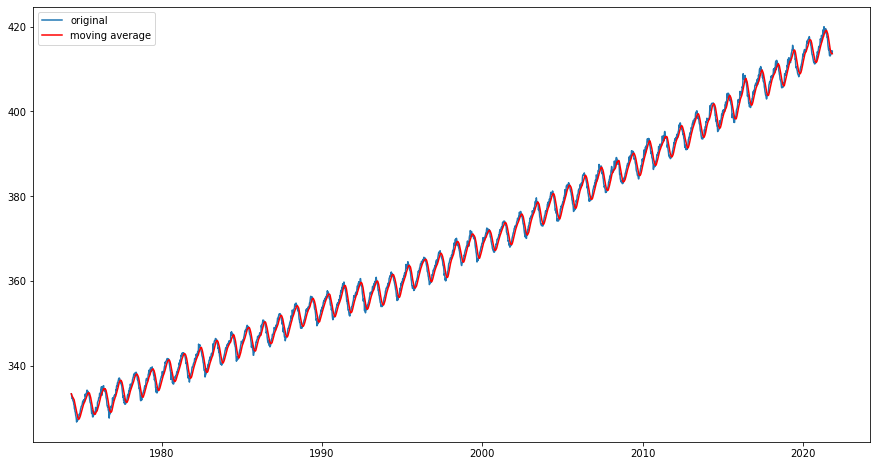

In [20]:
plt.plot(df,label='original')
plt.plot(df.rolling(10,min_periods=0).mean(),label='moving average',color='r')
plt.legend(loc='best')
plt.show()

In [21]:
# Model building - Exponential Smoothing Techniques

In [82]:
train = df.iloc[:2230,]
test = df.iloc[2230:,]

In [83]:
train.tail()

,CO2(PPM)
time_stamp,
2017-01-08,406.20
2017-01-15,406.41
2017-01-22,406.71
2017-01-29,406.43
2017-02-05,406.26


In [84]:
test.head()

,CO2(PPM)
time_stamp,
2017-02-12,406.14
2017-02-19,407.17
2017-02-26,407.60
2017-03-05,406.34
2017-03-12,407.77


In [85]:
len(train)

2230

In [86]:
len(test)

247

##### Simple Exponential Smoothing

In [87]:
SES = SimpleExpSmoothing(train,initialization_method='estimated')
SES_model = SES.fit(optimized=True)
SES_model.summary()

Dep. Variable:,CO2(PPM),No. Observations:,2230
Model:,SimpleExpSmoothing,SSE,692.533
Optimized:,True,AIC,-2603.764
Trend:,None,BIC,-2592.344
Seasonal:,None,AICC,-2603.746
Seasonal Periods:,None,Date:,"Sat, 02 Apr 2022"
Box-Cox:,False,Time:,01:54:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,333.37000,l.0,True


In [88]:
SES_predict = SES_model.forecast(len(test))

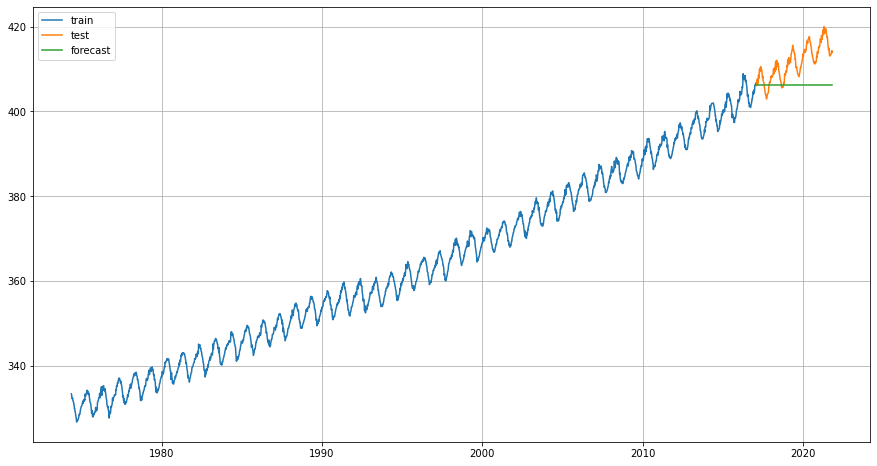

In [89]:
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(SES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [90]:
print("MAE:",MAE(test['CO2(PPM)'],SES_predict))
print("MAPE:",MAPE(test['CO2(PPM)'],SES_predict))

MAE: 5.556437244902118
MAPE: 1.3422274101257519


##### Double Exponential Smoothing

In [91]:
DES = Holt(train,exponential=False,initialization_method='estimated')
DES_model = DES.fit(optimized=True)
DES_model.summary()

Dep. Variable:,CO2(PPM),No. Observations:,2230
Model:,Holt,SSE,619.357
Optimized:,True,AIC,-2848.797
Trend:,Additive,BIC,-2825.958
Seasonal:,None,AICC,-2848.759
Seasonal Periods:,None,Date:,"Sat, 02 Apr 2022"
Box-Cox:,False,Time:,01:54:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6392015,alpha,True
smoothing_trend,0.3689935,beta,True


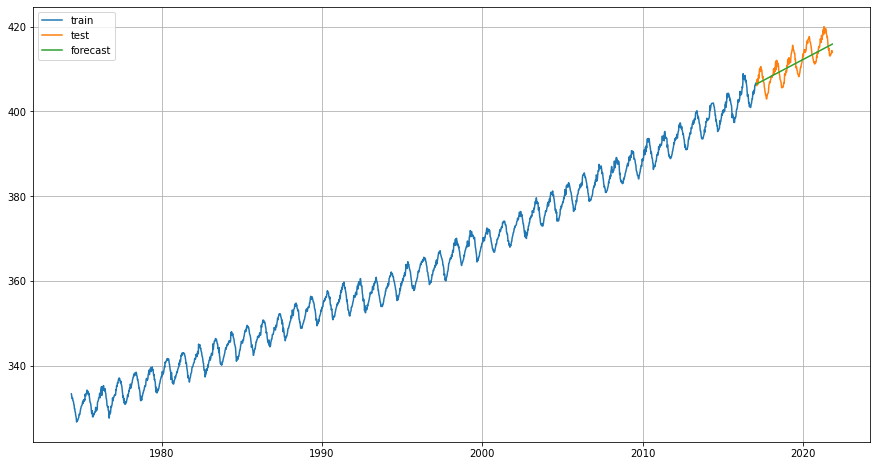

In [92]:
DES_predict = DES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(DES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [93]:
print("MAE:",MAE(test['CO2(PPM)'],DES_predict))
print("MAPE:",MAPE(test['CO2(PPM)'],DES_predict))

MAE: 2.0699233367379395
MAPE: 0.5024907256397109


##### Triple Exponential Smoothing

In [94]:
TES = ExponentialSmoothing(train,trend='multiplicative',seasonal='multiplicative',initialization_method='estimated')
TES_model = TES.fit(optimized=True)
TES_model.summary()

Dep. Variable:,CO2(PPM),No. Observations:,2230
Model:,ExponentialSmoothing,SSE,501.631
Optimized:,True,AIC,-3214.918
Trend:,Multiplicative,BIC,-2895.171
Seasonal:,Multiplicative,AICC,-3211.765
Seasonal Periods:,52,Date:,"Sat, 02 Apr 2022"
Box-Cox:,False,Time:,01:55:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1941496,alpha,True
smoothing_trend,0.000000,beta,True


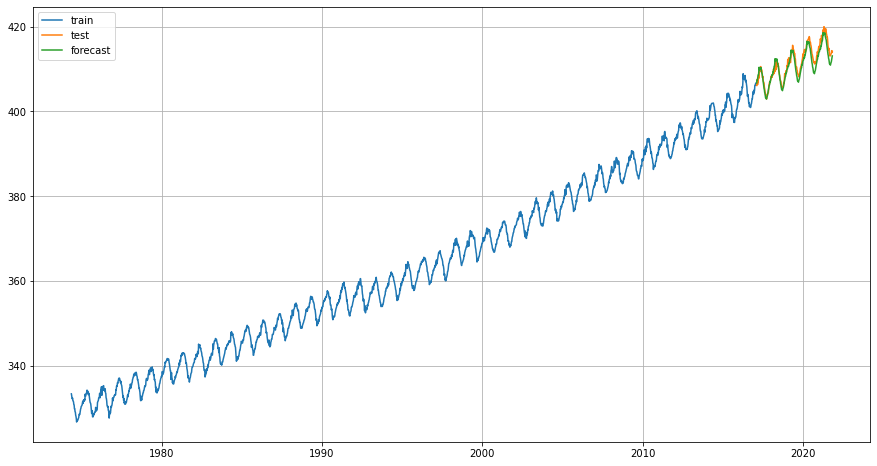

In [95]:
TES_predict = TES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(TES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [97]:
print("MAE:",MAE(test['CO2(PPM)'],TES_predict))
print("MAPE:",MAPE(test['CO2(PPM)'],TES_predict))

MAE: 1.0306015019338906
MAPE: 0.2496875225840626


##### ACF and PACF plots

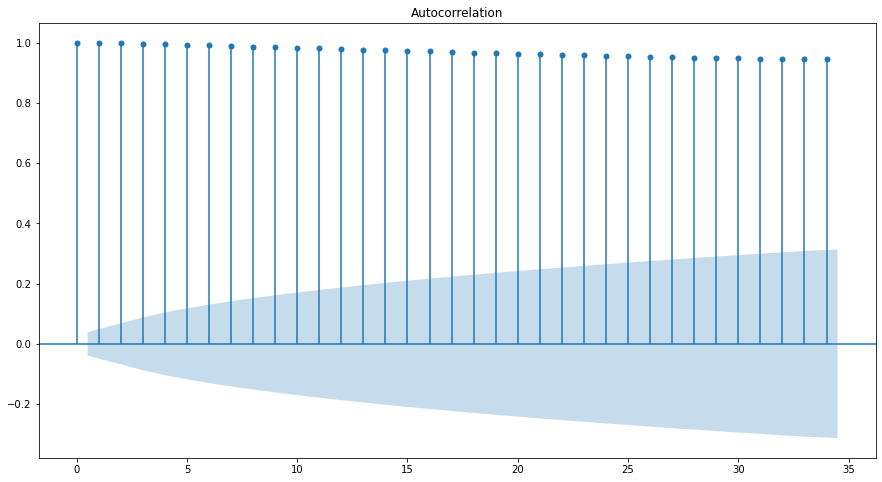

In [98]:
plot_acf(df)
plt.show()

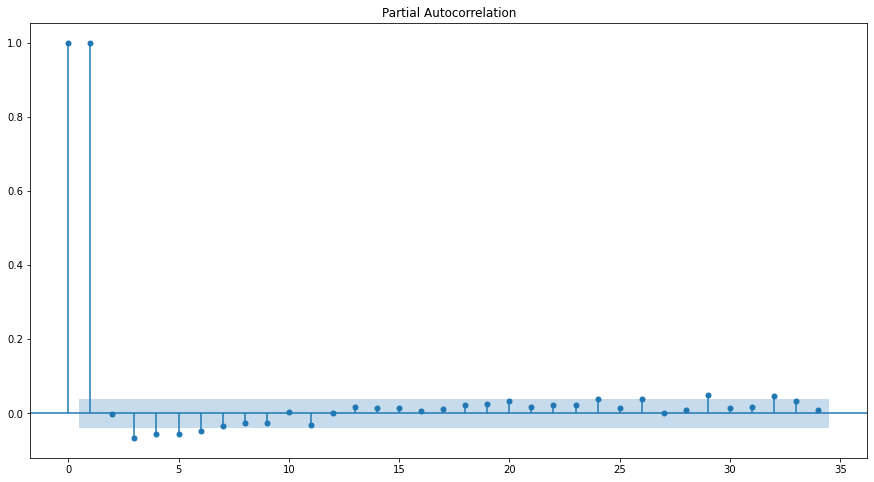

In [99]:
plot_pacf(df)
plt.show()

##### DickyFuller test

In [100]:
observations = df.values
df_results = adfuller(observations)
df_results

(0.2602687528157592,
 0.9754463827049912,
 27,
 2449,
 {'1%': -3.4330229961087557,
  '5%': -2.8627209046733073,
  '10%': -2.5673986431191405},
 3601.8708795865723)

In [215]:
##### Non-stationary series -- proceed with ARIMA & SARIMA model

In [87]:
diff = df.diff(periods=1).dropna()
observations_2 = diff.values
df_results_2 = adfuller(observations_2)
df_results_2

(-15.933792185533706,
 7.676504373100774e-29,
 27,
 2448,
 {'1%': -3.4330240891671138,
  '5%': -2.862721387359731,
  '10%': -2.5673989001091995},
 3570.707052887659)

##### ARIMA Model

In [88]:
import itertools

In [89]:
p = q = range(0,6)
d = range(1,2)
pdq = list(itertools.product(p,d,q))
print("Parameter combinations are:")
for i in range(1,len(pdq)):
    print("ARIMA",pdq[i])

Parameter combinations are:
ARIMA (0, 1, 1)
ARIMA (0, 1, 2)
ARIMA (0, 1, 3)
ARIMA (0, 1, 4)
ARIMA (0, 1, 5)
ARIMA (1, 1, 0)
ARIMA (1, 1, 1)
ARIMA (1, 1, 2)
ARIMA (1, 1, 3)
ARIMA (1, 1, 4)
ARIMA (1, 1, 5)
ARIMA (2, 1, 0)
ARIMA (2, 1, 1)
ARIMA (2, 1, 2)
ARIMA (2, 1, 3)
ARIMA (2, 1, 4)
ARIMA (2, 1, 5)
ARIMA (3, 1, 0)
ARIMA (3, 1, 1)
ARIMA (3, 1, 2)
ARIMA (3, 1, 3)
ARIMA (3, 1, 4)
ARIMA (3, 1, 5)
ARIMA (4, 1, 0)
ARIMA (4, 1, 1)
ARIMA (4, 1, 2)
ARIMA (4, 1, 3)
ARIMA (4, 1, 4)
ARIMA (4, 1, 5)
ARIMA (5, 1, 0)
ARIMA (5, 1, 1)
ARIMA (5, 1, 2)
ARIMA (5, 1, 3)
ARIMA (5, 1, 4)
ARIMA (5, 1, 5)


In [90]:
df_score_arima = pd.DataFrame(columns=['param','aic'])
df_score_arima

,param,aic


In [91]:
from warnings import filterwarnings
filterwarnings('ignore')

In [92]:
for param in pdq:
    try:
        model = ARIMA(train,order=param)
        arima_results = model.fit()
        print("ARIMA",param,"AIC:",arima_results.aic)
        df_score_arima = df_score_arima.append({'param':param,'aic':arima_results.aic},ignore_index=True)
    except:
        continue

ARIMA (0, 1, 0) AIC: 3716.3485165059146
ARIMA (0, 1, 1) AIC: 3718.279140748471
ARIMA (0, 1, 2) AIC: 3656.0787106465646
ARIMA (0, 1, 3) AIC: 3584.972896546523
ARIMA (0, 1, 4) AIC: 3497.599280353974
ARIMA (0, 1, 5) AIC: 3455.7582148881966
ARIMA (1, 1, 0) AIC: 3718.2526423146255
ARIMA (1, 1, 1) AIC: 3578.6689487622148
ARIMA (1, 1, 2) AIC: 3373.7942467978046
ARIMA (1, 1, 3) AIC: 3327.2002442248327
ARIMA (1, 1, 4) AIC: 3307.7636827767005
ARIMA (1, 1, 5) AIC: 3303.1522520246967
ARIMA (2, 1, 0) AIC: 3636.5304601038797
ARIMA (2, 1, 1) AIC: 3445.7487119985667
ARIMA (2, 1, 2) AIC: 3276.8248150288437
ARIMA (2, 1, 3) AIC: 3220.5102414643134
ARIMA (2, 1, 4) AIC: 3218.9611706285946
ARIMA (2, 1, 5) AIC: 3090.9910024697197
ARIMA (3, 1, 0) AIC: 3528.603144415262
ARIMA (3, 1, 1) AIC: 3402.179810026372
ARIMA (3, 1, 2) AIC: 3234.4507634119077
ARIMA (3, 1, 3) AIC: 3219.0701210880156
ARIMA (3, 1, 4) AIC: 3223.9353899504645
ARIMA (3, 1, 5) AIC: 3220.803731092145
ARIMA (4, 1, 0) AIC: 3419.3286479241187
ARIMA 

In [93]:
df_score_arima.sort_values('aic')

,param,aic
35,"(5, 1, 5)",3089.719419
17,"(2, 1, 5)",3090.991002
29,"(4, 1, 5)",3217.741340
16,"(2, 1, 4)",3218.961171
21,"(3, 1, 3)",3219.070121
32,"(5, 1, 2)",3219.239806
15,"(2, 1, 3)",3220.510241
23,"(3, 1, 5)",3220.803731
33,"(5, 1, 3)",3221.067283
28,"(4, 1, 4)",3221.409752


In [101]:
arima_model = ARIMA(train,(5,1,5))
arima_results = arima_model.fit()
print(arima_results.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.CO2(PPM)   No. Observations:                 2229
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -1532.860
Method:                       css-mle   S.D. of innovations              0.481
Date:                Sat, 02 Apr 2022   AIC                           3089.719
Time:                        02:20:08   BIC                           3158.231
Sample:                    05-26-1974   HQIC                          3114.738
                         - 02-05-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0337      0.002     20.347      0.000       0.030       0.037
ar.L1.D.CO2(PPM)     0.8527      0.073     11.667      0.000       0.709       0.996
ar.L2.D.CO2(PPM)     0.6213 

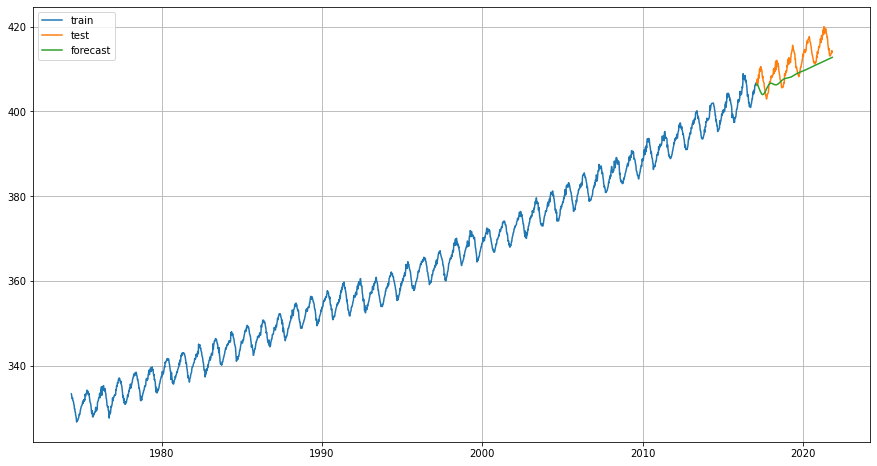

In [103]:
forecasted_values_arima = pd.Series(arima_results.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arima,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [104]:
print("MAE:",MAE(test['CO2(PPM)'],forecasted_values_arima))
print("MAPE:",MAPE(test['CO2(PPM)'],forecasted_values_arima))

MAE: 3.206972501774913
MAPE: 0.7756602369899437


##### SARIMA Model

In [98]:
p = q = range(0,6)
d = range(1,2)
pdq = list(itertools.product(p,d,q))
pdq_seasonal = [(x[0],x[1],x[2],5) for x in list(itertools.product(p,d,q))]

df_score = pd.DataFrame(columns=['param','seasonal','aic'])
df_score

,param,seasonal,aic


In [99]:
for param in pdq:
    for seasonal_param in pdq_seasonal:
        model = SARIMAX(train,
                       order = param,
                       seasonal_order = seasonal_param,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        sarimax_results = model.fit()
        print("SARIMAX",param,seasonal_param,'AIC:',sarimax_results.aic)
        df_score = df_score.append({'param':param,'seasonal':seasonal_param,'aic':sarimax_results.aic},ignore_index=True)

SARIMAX (0, 1, 0) (0, 1, 0, 5) AIC: 4803.843400319458
SARIMAX (0, 1, 0) (0, 1, 1, 5) AIC: 3729.719694818576
SARIMAX (0, 1, 0) (0, 1, 2, 5) AIC: 3660.2150324477884
SARIMAX (0, 1, 0) (0, 1, 3, 5) AIC: 3623.6408026630197
SARIMAX (0, 1, 0) (0, 1, 4, 5) AIC: 3615.4007542203085
SARIMAX (0, 1, 0) (0, 1, 5, 5) AIC: 3586.3834499844133
SARIMAX (0, 1, 0) (1, 1, 0, 5) AIC: 4317.830602707735
SARIMAX (0, 1, 0) (1, 1, 1, 5) AIC: 3659.5970202141607
SARIMAX (0, 1, 0) (1, 1, 2, 5) AIC: 3649.3830473912262
SARIMAX (0, 1, 0) (1, 1, 3, 5) AIC: 3624.7052798346467
SARIMAX (0, 1, 0) (1, 1, 4, 5) AIC: 3590.0608001819974
SARIMAX (0, 1, 0) (1, 1, 5, 5) AIC: 3569.8133275529144
SARIMAX (0, 1, 0) (2, 1, 0, 5) AIC: 4234.518135232033
SARIMAX (0, 1, 0) (2, 1, 1, 5) AIC: 3649.4396707422275
SARIMAX (0, 1, 0) (2, 1, 2, 5) AIC: 3640.7293822032907
SARIMAX (0, 1, 0) (2, 1, 3, 5) AIC: 3608.4072256028157
SARIMAX (0, 1, 0) (2, 1, 4, 5) AIC: 3383.3134807351835
SARIMAX (0, 1, 0) (2, 1, 5, 5) AIC: 3459.7948127400527
SARIMAX (0, 1,

SARIMAX (0, 1, 4) (1, 1, 1, 5) AIC: 3446.3102930780615
SARIMAX (0, 1, 4) (1, 1, 2, 5) AIC: 3441.1299355516444
SARIMAX (0, 1, 4) (1, 1, 3, 5) AIC: 3427.0300080683132
SARIMAX (0, 1, 4) (1, 1, 4, 5) AIC: 3423.6246905817925
SARIMAX (0, 1, 4) (1, 1, 5, 5) AIC: 3394.8861640393907
SARIMAX (0, 1, 4) (2, 1, 0, 5) AIC: 4016.50081560541
SARIMAX (0, 1, 4) (2, 1, 1, 5) AIC: 3448.0123166977382
SARIMAX (0, 1, 4) (2, 1, 2, 5) AIC: 3436.4231491298005
SARIMAX (0, 1, 4) (2, 1, 3, 5) AIC: 3418.244588269285
SARIMAX (0, 1, 4) (2, 1, 4, 5) AIC: 3412.4041803762293
SARIMAX (0, 1, 4) (2, 1, 5, 5) AIC: 3397.3841014391755
SARIMAX (0, 1, 4) (3, 1, 0, 5) AIC: 3945.1719330283418
SARIMAX (0, 1, 4) (3, 1, 1, 5) AIC: 3433.426222381888
SARIMAX (0, 1, 4) (3, 1, 2, 5) AIC: 3411.37287001971
SARIMAX (0, 1, 4) (3, 1, 3, 5) AIC: 3417.3780396884576
SARIMAX (0, 1, 4) (3, 1, 4, 5) AIC: 3413.2983427566633
SARIMAX (0, 1, 4) (3, 1, 5, 5) AIC: 3156.3194201688048
SARIMAX (0, 1, 4) (4, 1, 0, 5) AIC: 3865.583801044324
SARIMAX (0, 1, 4)

ValueError: Invalid model: moving average lag(s) {5} are in both the seasonal and non-seasonal moving average components.

In [100]:
df_score.sort_values('aic')

,param,seasonal,aic
173,"(0, 1, 4)","(4, 1, 5, 5)",3091.461153
137,"(0, 1, 3)","(4, 1, 5, 5)",3101.612905
65,"(0, 1, 1)","(4, 1, 5, 5)",3109.853009
179,"(0, 1, 4)","(5, 1, 5, 5)",3111.544946
101,"(0, 1, 2)","(4, 1, 5, 5)",3112.980470
...,...,...,...
144,"(0, 1, 4)","(0, 1, 0, 5)",4503.620175
108,"(0, 1, 3)","(0, 1, 0, 5)",4570.846315
72,"(0, 1, 2)","(0, 1, 0, 5)",4667.632992
36,"(0, 1, 1)","(0, 1, 0, 5)",4688.343614


In [141]:
model = SARIMAX(train,
                       order = (0,1,4),
                       seasonal_order = (4,1,5,5),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarimax_results = model.fit()

In [142]:
print(sarimax_results.summary())

                                            SARIMAX Results                                            
Dep. Variable:                                        CO2(PPM)   No. Observations:                 2230
Model:             SARIMAX(0, 1, 4)x(4, 1, [1, 2, 3, 4, 5], 5)   Log Likelihood               -1531.731
Date:                                         Sat, 02 Apr 2022   AIC                           3091.461
Time:                                                 02:36:02   BIC                           3171.170
Sample:                                             05-19-1974   HQIC                          3120.592
                                                  - 02-05-2017                                         
Covariance Type:                                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1     

In [143]:
forecast = sarimax_results.forecast(len(test))

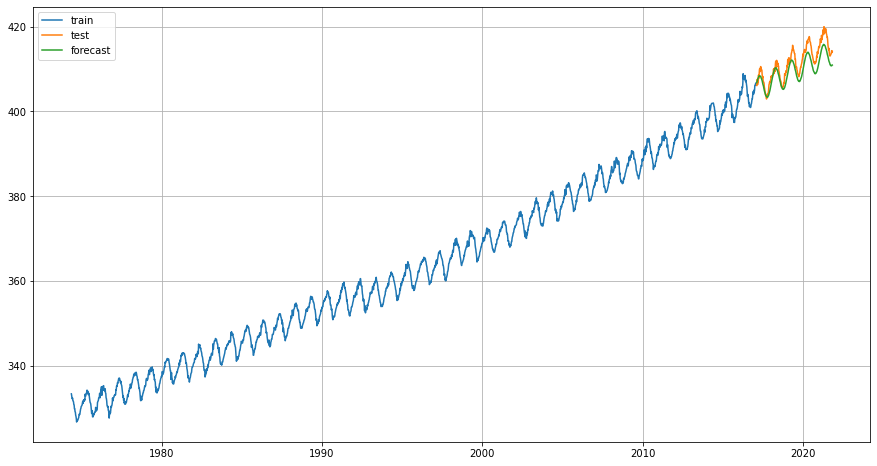

In [144]:
# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecast,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [145]:
print("MAE:",MAE(test['CO2(PPM)'],forecast))
print("MAPE:",MAPE(test['CO2(PPM)'],forecast))

MAE: 2.065895019025955
MAPE: 0.4999515266827652


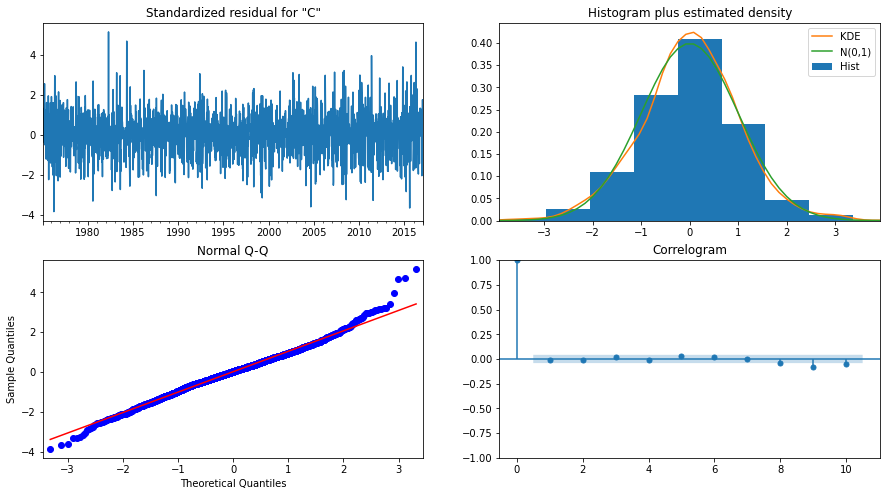

In [146]:
sarimax_results.plot_diagnostics();